# MARBERT v2 8-Fold Cross-Validation Ensemble Training

## Overview
This notebook trains 8 MARBERT v2 models using 8-fold cross-validation and combines them into an ensemble classifier for final predictions on the dev set.

## Ensemble Strategy
- **Models:** 8 MARBERT v2 models (one per fold)
- **Ensemble Method:** Soft voting (averaging predicted probabilities)
- **Training:** Each model trained on 7/8 of the data
- **Validation:** Each model evaluated on held-out 1/8 fold

## Configuration
- **Model:** MARBERT v2 (UBC-NLP/MARBERTv2)
- **Preprocessing:** Basic (character normalization)
- **Folds:** 8
- **Epochs per model:** 4
- **Learning Rate:** 2e-5
- **Batch Size:** 16
- **Warmup Steps:** 500
- **Weight Decay:** 0.01

## Memory Management (16GB VRAM Safe!)
- **Strategy:** Train one model at a time, save to disk, clear GPU memory
- **Peak VRAM:** ~4-5GB per model during training (well within 16GB limit)
- **Inference:** Load one model at a time for predictions (~2-3GB)
- **Disk Space:** ~2GB per model × 8 = ~16GB total disk space needed

## Expected Benefits
- Reduced variance through model averaging
- More robust predictions
- Better generalization to unseen data

## 1. Setup & Imports

In [ ]:
%pip install transformers datasets torch scikit-learn -q

In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4
Memory: 14.74 GB


## 2. Load Preprocessed Data

**Training data:** `../train/arb_clean_basic.csv` with columns: `id`, `text`, `polarization`  
**Dev data:** `../dev/arb_clean.csv` with columns: `id`, `text_clean`

In [3]:
# Load full training data
train_df = pd.read_csv('arb_clean_basic.csv')

print(f"Training set size: {len(train_df)}")
print(f"Columns: {train_df.columns.tolist()}")
print(f"\nClass distribution:")
print(train_df['polarization'].value_counts())
print(f"\nClass balance:")
print(train_df['polarization'].value_counts(normalize=True))
print(f"\nSample training data:")
print(train_df.head(3))

Training set size: 3380
Columns: ['id', 'text', 'polarization']

Class distribution:
polarization
0    1868
1    1512
Name: count, dtype: int64

Class balance:
polarization
0    0.552663
1    0.447337
Name: proportion, dtype: float64

Sample training data:
                                     id  \
0  arb_a2a60c8b4af3389e842d8ec31afb0eea   
1  arb_6723e56a672674a6c1d9b28b213c4a05   
2  arb_b0365d606edeee38ae6c025b1ca33e96   

                                                text  polarization  
0  احلام انتي ونعالي ومنو انتي حتي تقيمين الفناني...             1  
1  وره الكواليس تنيجج من وره بعير صطناعي علي فكرة...             1  
2  .خخخخ الملكه احلام فيها شذوذ شنو هل بوس والدلع...             1  


In [4]:
# Load preprocessed dev data
dev_df = pd.read_csv('arb_clean.csv')

print(f"Dev set size: {len(dev_df)}")
print(f"Columns: {dev_df.columns.tolist()}")
print(f"\nSample dev data:")
print(dev_df.head(3))

Dev set size: 169
Columns: ['id', 'text_clean']

Sample dev data:
                                     id  \
0  arb_67be47e5216d7bee41e17484e619f4e6   
1  arb_272322e5b265e177613d685e5619e402   
2  arb_d1ec38dd0ec5d7a4fe28ef8317fc96c1   

                                          text_clean  
0  حيل بيج يانذله تحجين ع العراقيات بس احنه العرا...  
1  علي زبي\nيا ليتها تجي معي البر اخليها تسوق دبا...  
2  كل المغنين ولي يدخلون  المسيقه  في  اغانيهم  ن...  


## 3. Setup Tokenizer

In [5]:
# Load tokenizer
model_name = "UBC-NLP/MARBERTv2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"Tokenizer loaded: {model_name}")
print(f"Vocab size: {tokenizer.vocab_size}")

tokenizer_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizer loaded: UBC-NLP/MARBERTv2
Vocab size: 100000


## 4. Tokenization Functions

In [6]:
# Tokenization function for training data
def tokenize_function_train(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

# Tokenization function for dev data
def tokenize_function_dev(examples):
    return tokenizer(
        examples['text_clean'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

print("✓ Tokenization functions defined")

✓ Tokenization functions defined


## 5. Prepare Dev Dataset (tokenize once)

In [7]:
# Prepare dev dataset
dev_dataset = Dataset.from_pandas(dev_df[['text_clean']])

print("Tokenizing dev data...")
dev_dataset_tokenized = dev_dataset.map(tokenize_function_dev, batched=True)
dev_dataset_tokenized.set_format('torch', columns=['input_ids', 'attention_mask'])

print(f"✓ Dev dataset tokenized: {len(dev_dataset_tokenized)} samples")

Tokenizing dev data...


Map:   0%|          | 0/169 [00:00<?, ? examples/s]

✓ Dev dataset tokenized: 169 samples


## 6. Setup 8-Fold Cross-Validation

In [ ]:
# Setup stratified k-fold
RANDOM_SEED = 42
N_FOLDS = 8

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

print(f"✓ 8-Fold Cross-Validation configured")
print(f"  Random Seed: {RANDOM_SEED}")
print(f"  Number of Folds: {N_FOLDS}")
print(f"  Stratification: Enabled")

✓ 10-Fold Cross-Validation configured
  Random Seed: 42
  Number of Folds: 10
  Stratification: Enabled


## 7. Training Configuration

In [9]:
# Training hyperparameters (best configuration from finetuning)
training_config = {
    'num_train_epochs': 4,
    'per_device_train_batch_size': 16,
    'per_device_eval_batch_size': 32,
    'learning_rate': 2e-5,
    'weight_decay': 0.01,
    'warmup_steps': 500,
    'logging_steps': 50,
    'save_strategy': 'epoch',
    'fp16': torch.cuda.is_available(),
    'seed': RANDOM_SEED
}

print("Training Configuration:")
for key, value in training_config.items():
    print(f"  {key}: {value}")

Training Configuration:
  num_train_epochs: 4
  per_device_train_batch_size: 16
  per_device_eval_batch_size: 32
  learning_rate: 2e-05
  weight_decay: 0.01
  warmup_steps: 500
  logging_steps: 50
  save_strategy: epoch
  fp16: True
  seed: 42


## 8. Helper Functions

In [10]:
def compute_metrics(eval_pred):
    """Compute metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1': f1
    }

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

print("✓ Helper functions defined")

✓ Helper functions defined


## 9. Train 8-Fold Models

This will train 8 models, one for each fold. Each model is trained on 87.5% of the data and validated on the remaining 12.5%.

**Memory Management:** Models are saved to disk and cleared from GPU memory after training to avoid OOM errors with 16GB VRAM.

In [ ]:
import os
import gc

# Storage for model paths and results (NOT storing models in memory)
model_paths = []
fold_results = []

# Create directory for saved models
os.makedirs('./saved_models', exist_ok=True)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Get indices for stratified k-fold
X = train_df['text'].values
y = train_df['polarization'].values

print("="*80)
print("STARTING 8-FOLD CROSS-VALIDATION TRAINING")
print("="*80)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n{'='*80}")
    print(f"FOLD {fold}/{N_FOLDS}")
    print(f"{'='*80}")

    # Split data
    fold_train_df = train_df.iloc[train_idx].reset_index(drop=True)
    fold_val_df = train_df.iloc[val_idx].reset_index(drop=True)

    print(f"Training samples: {len(fold_train_df)}")
    print(f"Validation samples: {len(fold_val_df)}")
    print(f"Train class distribution: {fold_train_df['polarization'].value_counts().to_dict()}")
    print(f"Val class distribution: {fold_val_df['polarization'].value_counts().to_dict()}")

    # Create datasets
    fold_train_dataset = Dataset.from_pandas(fold_train_df[['text', 'polarization']])
    fold_val_dataset = Dataset.from_pandas(fold_val_df[['text', 'polarization']])

    # Tokenize
    fold_train_dataset = fold_train_dataset.map(tokenize_function_train, batched=True)
    fold_train_dataset = fold_train_dataset.rename_column('polarization', 'labels')
    fold_train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

    fold_val_dataset = fold_val_dataset.map(tokenize_function_train, batched=True)
    fold_val_dataset = fold_val_dataset.rename_column('polarization', 'labels')
    fold_val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

    # Load fresh model for this fold
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2
    )

    # Training arguments for this fold
    training_args = TrainingArguments(
        output_dir=f'./results_fold_{fold}',
        num_train_epochs=training_config['num_train_epochs'],
        per_device_train_batch_size=training_config['per_device_train_batch_size'],
        per_device_eval_batch_size=training_config['per_device_eval_batch_size'],
        learning_rate=training_config['learning_rate'],
        weight_decay=training_config['weight_decay'],
        warmup_steps=training_config['warmup_steps'],
        logging_dir=f'./logs_fold_{fold}',
        logging_steps=training_config['logging_steps'],
        eval_strategy="epoch",
        save_strategy=training_config['save_strategy'],
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        seed=training_config['seed'],
        fp16=training_config['fp16'],
        report_to='none'
    )

    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=fold_train_dataset,
        eval_dataset=fold_val_dataset,
        compute_metrics=compute_metrics,
        data_collator=data_collator
    )

    # Train
    print(f"\nTraining Fold {fold}...")
    trainer.train()

    # Evaluate on validation fold
    print(f"\nEvaluating Fold {fold}...")
    eval_results = trainer.evaluate()

    print(f"\nFold {fold} Results:")
    print(f"  Validation Accuracy: {eval_results['eval_accuracy']:.4f}")
    print(f"  Validation F1 Score: {eval_results['eval_f1']:.4f}")

    # Save model to disk (important for memory management!)
    model_save_path = f'./saved_models/fold_{fold}_model'
    trainer.save_model(model_save_path)
    print(f"  Model saved to: {model_save_path}")

    # Store path and results
    model_paths.append(model_save_path)
    fold_results.append({
        'fold': fold,
        'accuracy': eval_results['eval_accuracy'],
        'f1': eval_results['eval_f1']
    })

    # Get detailed predictions for this fold
    predictions = trainer.predict(fold_val_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    print(f"\nDetailed Classification Report (Fold {fold}):")
    print(classification_report(labels, preds, target_names=['Class 0', 'Class 1']))

    # CRITICAL: Clear GPU memory after each fold
    del model, trainer, fold_train_dataset, fold_val_dataset, predictions
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    print(f"  GPU memory cleared")


print("\n" + "="*80)
print("8-FOLD CROSS-VALIDATION COMPLETE")
print("="*80)

STARTING 10-FOLD CROSS-VALIDATION TRAINING

FOLD 1/10
Training samples: 3042
Validation samples: 338
Train class distribution: {0: 1682, 1: 1360}
Val class distribution: {0: 186, 1: 152}


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Fold 1...


model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.616800,0.440935,0.781065,0.781065
2,0.365400,0.403508,0.816568,0.816452
3,0.260000,0.462943,0.825444,0.825390
4,0.128100,0.578069,0.843195,0.843241



Evaluating Fold 1...



Fold 1 Results:
  Validation Accuracy: 0.8432
  Validation F1 Score: 0.8432
  Model saved to: ./saved_models/fold_1_model

Detailed Classification Report (Fold 1):
              precision    recall  f1-score   support

     Class 0       0.86      0.85      0.86       186
     Class 1       0.82      0.83      0.83       152

    accuracy                           0.84       338
   macro avg       0.84      0.84      0.84       338
weighted avg       0.84      0.84      0.84       338

  GPU memory cleared

FOLD 2/10
Training samples: 3042
Validation samples: 338
Train class distribution: {0: 1682, 1: 1360}
Val class distribution: {0: 186, 1: 152}


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Fold 2...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.593900,0.485227,0.772189,0.771184
2,0.381000,0.382797,0.831361,0.831309
3,0.305700,0.419131,0.804734,0.804844
4,0.137100,0.573558,0.825444,0.825587



Evaluating Fold 2...



Fold 2 Results:
  Validation Accuracy: 0.8314
  Validation F1 Score: 0.8313
  Model saved to: ./saved_models/fold_2_model

Detailed Classification Report (Fold 2):
              precision    recall  f1-score   support

     Class 0       0.93      0.75      0.83       186
     Class 1       0.75      0.93      0.83       152

    accuracy                           0.83       338
   macro avg       0.84      0.84      0.83       338
weighted avg       0.85      0.83      0.83       338

  GPU memory cleared

FOLD 3/10
Training samples: 3042
Validation samples: 338
Train class distribution: {0: 1681, 1: 1361}
Val class distribution: {0: 187, 1: 151}


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Fold 3...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.589300,0.460717,0.786982,0.786505
2,0.388300,0.408508,0.795858,0.795791
3,0.288000,0.417715,0.825444,0.825126
4,0.130400,0.670123,0.807692,0.807177



Evaluating Fold 3...



Fold 3 Results:
  Validation Accuracy: 0.8254
  Validation F1 Score: 0.8251
  Model saved to: ./saved_models/fold_3_model

Detailed Classification Report (Fold 3):
              precision    recall  f1-score   support

     Class 0       0.83      0.86      0.84       187
     Class 1       0.82      0.79      0.80       151

    accuracy                           0.83       338
   macro avg       0.82      0.82      0.82       338
weighted avg       0.83      0.83      0.83       338

  GPU memory cleared

FOLD 4/10
Training samples: 3042
Validation samples: 338
Train class distribution: {0: 1681, 1: 1361}
Val class distribution: {0: 187, 1: 151}


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Fold 4...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.589400,0.451767,0.792899,0.793308
2,0.383900,0.390942,0.831361,0.831827
3,0.287300,0.470437,0.825444,0.825387
4,0.076800,0.652085,0.819527,0.819339



Evaluating Fold 4...



Fold 4 Results:
  Validation Accuracy: 0.8314
  Validation F1 Score: 0.8318
  Model saved to: ./saved_models/fold_4_model

Detailed Classification Report (Fold 4):
              precision    recall  f1-score   support

     Class 0       0.89      0.79      0.84       187
     Class 1       0.77      0.88      0.82       151

    accuracy                           0.83       338
   macro avg       0.83      0.84      0.83       338
weighted avg       0.84      0.83      0.83       338

  GPU memory cleared

FOLD 5/10
Training samples: 3042
Validation samples: 338
Train class distribution: {0: 1681, 1: 1361}
Val class distribution: {0: 187, 1: 151}


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Fold 5...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.584800,0.459089,0.778107,0.778736
2,0.362800,0.427779,0.789941,0.790123
3,0.279200,0.449554,0.828402,0.828795
4,0.126100,0.653770,0.822485,0.822836



Evaluating Fold 5...



Fold 5 Results:
  Validation Accuracy: 0.8284
  Validation F1 Score: 0.8288
  Model saved to: ./saved_models/fold_5_model

Detailed Classification Report (Fold 5):
              precision    recall  f1-score   support

     Class 0       0.86      0.82      0.84       187
     Class 1       0.79      0.84      0.81       151

    accuracy                           0.83       338
   macro avg       0.83      0.83      0.83       338
weighted avg       0.83      0.83      0.83       338

  GPU memory cleared

FOLD 6/10
Training samples: 3042
Validation samples: 338
Train class distribution: {0: 1681, 1: 1361}
Val class distribution: {0: 187, 1: 151}


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Fold 6...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.587300,0.449702,0.786982,0.787588
2,0.367700,0.367281,0.843195,0.843640
3,0.279300,0.401139,0.843195,0.843575
4,0.111200,0.672535,0.831361,0.830583



Evaluating Fold 6...



Fold 6 Results:
  Validation Accuracy: 0.8432
  Validation F1 Score: 0.8436
  Model saved to: ./saved_models/fold_6_model

Detailed Classification Report (Fold 6):
              precision    recall  f1-score   support

     Class 0       0.89      0.81      0.85       187
     Class 1       0.79      0.88      0.83       151

    accuracy                           0.84       338
   macro avg       0.84      0.85      0.84       338
weighted avg       0.85      0.84      0.84       338

  GPU memory cleared

FOLD 7/10
Training samples: 3042
Validation samples: 338
Train class distribution: {0: 1681, 1: 1361}
Val class distribution: {0: 187, 1: 151}


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Fold 7...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.595000,0.444161,0.810651,0.809888
2,0.382400,0.418921,0.825444,0.824984
3,0.296100,0.443846,0.825444,0.825681
4,0.110500,0.606441,0.822485,0.822767



Evaluating Fold 7...



Fold 7 Results:
  Validation Accuracy: 0.8254
  Validation F1 Score: 0.8257
  Model saved to: ./saved_models/fold_7_model

Detailed Classification Report (Fold 7):
              precision    recall  f1-score   support

     Class 0       0.91      0.76      0.83       187
     Class 1       0.75      0.91      0.82       151

    accuracy                           0.83       338
   macro avg       0.83      0.83      0.83       338
weighted avg       0.84      0.83      0.83       338

  GPU memory cleared

FOLD 8/10
Training samples: 3042
Validation samples: 338
Train class distribution: {0: 1681, 1: 1361}
Val class distribution: {0: 187, 1: 151}


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Fold 8...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.592100,0.432691,0.819527,0.819911
2,0.362100,0.368880,0.843195,0.843640
3,0.279400,0.445323,0.855030,0.855289
4,0.128100,0.622471,0.834320,0.834419



Evaluating Fold 8...



Fold 8 Results:
  Validation Accuracy: 0.8550
  Validation F1 Score: 0.8553
  Model saved to: ./saved_models/fold_8_model

Detailed Classification Report (Fold 8):
              precision    recall  f1-score   support

     Class 0       0.88      0.85      0.87       187
     Class 1       0.82      0.86      0.84       151

    accuracy                           0.86       338
   macro avg       0.85      0.86      0.85       338
weighted avg       0.86      0.86      0.86       338

  GPU memory cleared

FOLD 9/10
Training samples: 3042
Validation samples: 338
Train class distribution: {0: 1681, 1: 1361}
Val class distribution: {0: 187, 1: 151}


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Fold 9...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.592400,0.478540,0.760355,0.758747
2,0.378500,0.409196,0.795858,0.796223
3,0.257100,0.617569,0.789941,0.789564
4,0.129700,0.699232,0.804734,0.805261



Evaluating Fold 9...



Fold 9 Results:
  Validation Accuracy: 0.8047
  Validation F1 Score: 0.8053
  Model saved to: ./saved_models/fold_9_model

Detailed Classification Report (Fold 9):
              precision    recall  f1-score   support

     Class 0       0.87      0.76      0.81       187
     Class 1       0.75      0.85      0.80       151

    accuracy                           0.80       338
   macro avg       0.81      0.81      0.80       338
weighted avg       0.81      0.80      0.81       338

  GPU memory cleared

FOLD 10/10
Training samples: 3042
Validation samples: 338
Train class distribution: {0: 1681, 1: 1361}
Val class distribution: {0: 187, 1: 151}


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Fold 10...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.595200,0.435461,0.813609,0.814008
2,0.418600,0.358484,0.828402,0.828884


SafetensorError: Error while serializing: I/O error: No space left on device (os error 28)

## 10. Cross-Validation Results Summary

10-FOLD CROSS-VALIDATION RESULTS

Per-Fold Results:
 fold  accuracy       f1
    1  0.843195 0.843241
    2  0.831361 0.831309
    3  0.825444 0.825126
    4  0.831361 0.831827
    5  0.828402 0.828795
    6  0.843195 0.843640
    7  0.825444 0.825681
    8  0.855030 0.855289
    9  0.804734 0.805261

SUMMARY STATISTICS
Mean Accuracy: 0.8320 ± 0.0142
Mean F1 Score: 0.8322 ± 0.0142

Min F1 Score: 0.8053 (Fold 9)
Max F1 Score: 0.8553 (Fold 8)

95% Confidence Interval: [0.8234, 0.8411]


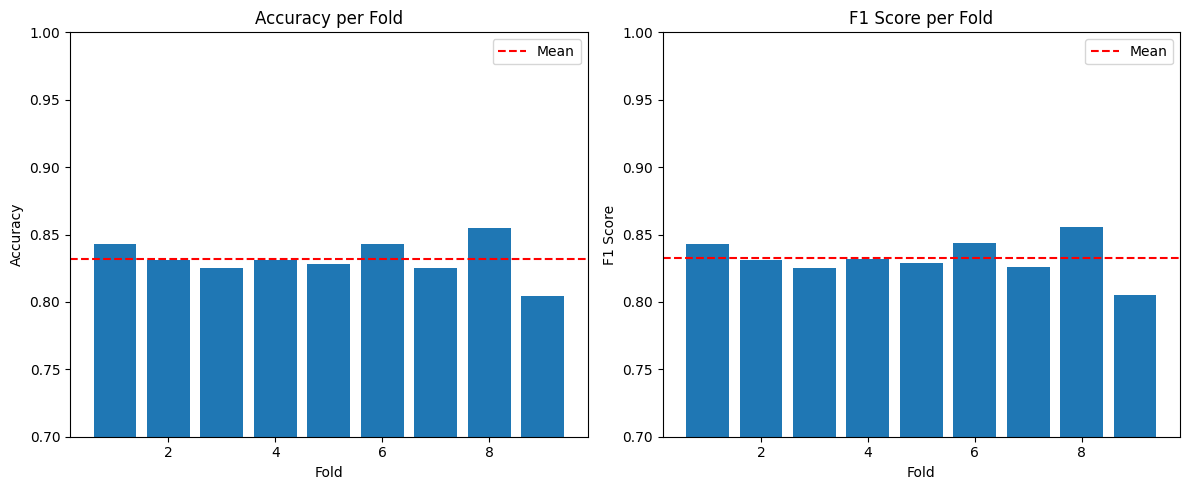


✓ Trained and saved 9 models successfully
✓ Models saved to disk to conserve GPU memory


In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(fold_results)

print("="*80)
print("8-FOLD CROSS-VALIDATION RESULTS")
print("="*80)
print("\nPer-Fold Results:")
print(results_df.to_string(index=False))

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print(f"{'='*80}")
print(f"Mean Accuracy: {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Mean F1 Score: {results_df['f1'].mean():.4f} ± {results_df['f1'].std():.4f}")
print(f"\nMin F1 Score: {results_df['f1'].min():.4f} (Fold {results_df.loc[results_df['f1'].idxmin(), 'fold']})")
print(f"Max F1 Score: {results_df['f1'].max():.4f} (Fold {results_df.loc[results_df['f1'].idxmax(), 'fold']})")

# 95% confidence interval
f1_mean = results_df['f1'].mean()
f1_std = results_df['f1'].std()
f1_ci_lower = f1_mean - 1.96 * f1_std / np.sqrt(N_FOLDS)
f1_ci_upper = f1_mean + 1.96 * f1_std / np.sqrt(N_FOLDS)
print(f"\n95% Confidence Interval: [{f1_ci_lower:.4f}, {f1_ci_upper:.4f}]")

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(results_df['fold'], results_df['accuracy'])
plt.axhline(y=results_df['accuracy'].mean(), color='r', linestyle='--', label='Mean')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy per Fold')
plt.legend()
plt.ylim([0.7, 1.0])

plt.subplot(1, 2, 2)
plt.bar(results_df['fold'], results_df['f1'])
plt.axhline(y=results_df['f1'].mean(), color='r', linestyle='--', label='Mean')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('F1 Score per Fold')
plt.legend()
plt.ylim([0.7, 1.0])

plt.tight_layout()
plt.show()

print(f"\n✓ Trained and saved {len(model_paths)} models successfully")
print(f"✓ Models saved to disk to conserve GPU memory")

## 11. Ensemble Predictions on Dev Set

Use soft voting: average the predicted probabilities from all 8 models, then take the argmax for final prediction.

**Memory-Efficient Loading:** Load one model at a time, get predictions, then unload to save GPU memory.

In [ ]:
print("="*80)
print("GENERATING ENSEMBLE PREDICTIONS ON DEV SET")
print("="*80)

# Storage for all predictions
all_predictions = []

# Get predictions from each model (load one at a time to save memory)
for fold, model_path in enumerate(model_paths, 1):
    print(f"Loading and evaluating Fold {fold} model...")

    # Load model from disk
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.eval()
    model.to('cuda' if torch.cuda.is_available() else 'cpu')

    # Create a temporary trainer just for prediction
    temp_trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir='./temp',
            per_device_eval_batch_size=32,
            fp16=torch.cuda.is_available(),
            report_to='none'
        ),
        data_collator=data_collator
    )

    # Get predictions (logits)
    predictions = temp_trainer.predict(dev_dataset_tokenized)

    # Convert logits to probabilities using softmax
    probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()
    all_predictions.append(probs)

    print(f"  Shape: {probs.shape}, Class 1 prob range: [{probs[:, 1].min():.3f}, {probs[:, 1].max():.3f}]")

    # CRITICAL: Clear GPU memory after each model
    del model, temp_trainer, predictions
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

# Convert to numpy array for easier manipulation
all_predictions = np.array(all_predictions)  # Shape: (8, n_samples, 2)

print(f"\n✓ Collected predictions from all {len(model_paths)} models")
print(f"  Prediction array shape: {all_predictions.shape}")

GENERATING ENSEMBLE PREDICTIONS ON DEV SET
Loading and evaluating Fold 1 model...


  Shape: (169, 2), Class 1 prob range: [0.003, 0.995]
Loading and evaluating Fold 2 model...


  Shape: (169, 2), Class 1 prob range: [0.024, 0.939]
Loading and evaluating Fold 3 model...


  Shape: (169, 2), Class 1 prob range: [0.009, 0.978]
Loading and evaluating Fold 4 model...


  Shape: (169, 2), Class 1 prob range: [0.022, 0.945]
Loading and evaluating Fold 5 model...


  Shape: (169, 2), Class 1 prob range: [0.008, 0.980]
Loading and evaluating Fold 6 model...


  Shape: (169, 2), Class 1 prob range: [0.023, 0.929]
Loading and evaluating Fold 7 model...


  Shape: (169, 2), Class 1 prob range: [0.009, 0.982]
Loading and evaluating Fold 8 model...


  Shape: (169, 2), Class 1 prob range: [0.008, 0.978]
Loading and evaluating Fold 9 model...


  Shape: (169, 2), Class 1 prob range: [0.003, 0.993]

✓ Collected predictions from all 9 models
  Prediction array shape: (9, 169, 2)


In [15]:
# Ensemble: Average probabilities across all models
ensemble_probs = all_predictions.mean(axis=0)  # Shape: (n_samples, 2)

# Get final predictions
ensemble_predictions = np.argmax(ensemble_probs, axis=1)

print("="*80)
print("ENSEMBLE PREDICTIONS COMPLETE")
print("="*80)
print(f"Total predictions: {len(ensemble_predictions)}")
print(f"\nPrediction distribution:")
unique, counts = np.unique(ensemble_predictions, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Class {label}: {count} ({count/len(ensemble_predictions)*100:.1f}%)")

print(f"\nEnsemble probability statistics:")
print(f"  Class 0 prob - Mean: {ensemble_probs[:, 0].mean():.3f}, Std: {ensemble_probs[:, 0].std():.3f}")
print(f"  Class 1 prob - Mean: {ensemble_probs[:, 1].mean():.3f}, Std: {ensemble_probs[:, 1].std():.3f}")

# Confidence analysis
confidence = ensemble_probs.max(axis=1)
print(f"\nPrediction confidence:")
print(f"  Mean: {confidence.mean():.3f}")
print(f"  Min: {confidence.min():.3f}")
print(f"  Max: {confidence.max():.3f}")
print(f"  Median: {np.median(confidence):.3f}")

# High confidence predictions
high_conf_threshold = 0.9
high_conf_count = (confidence > high_conf_threshold).sum()
print(f"\nHigh confidence predictions (>{high_conf_threshold}): {high_conf_count} ({high_conf_count/len(confidence)*100:.1f}%)")

ENSEMBLE PREDICTIONS COMPLETE
Total predictions: 169

Prediction distribution:
  Class 0: 90 (53.3%)
  Class 1: 79 (46.7%)

Ensemble probability statistics:
  Class 0 prob - Mean: 0.550, Std: 0.400
  Class 1 prob - Mean: 0.450, Std: 0.400

Prediction confidence:
  Mean: 0.885
  Min: 0.502
  Max: 0.987
  Median: 0.927

High confidence predictions (>0.9): 100 (59.2%)


## 12. Create Submission File

Following the submission guidelines:
- File format: CSV with columns `id` and `polarization`
- File name: `pred_arb.csv`
- Values: 0 or 1 for polarization labels

In [16]:
# Create submission dataframe
submission_df = pd.DataFrame({
    'id': dev_df['id'],
    'polarization': ensemble_predictions
})

# Save to CSV
output_file = 'pred_arb_ensemble.csv'
submission_df.to_csv(output_file, index=False)

print(f"✓ Submission file created: {output_file}")
print(f"\nFile preview:")
print(submission_df.head(10))
print(f"\nFile preview (tail):")
print(submission_df.tail(10))
print(f"\nTotal predictions: {len(submission_df)}")

✓ Submission file created: pred_arb_ensemble.csv

File preview:
                                     id  polarization
0  arb_67be47e5216d7bee41e17484e619f4e6             1
1  arb_272322e5b265e177613d685e5619e402             1
2  arb_d1ec38dd0ec5d7a4fe28ef8317fc96c1             1
3  arb_fad75310b17c124d98ebc514189ec033             1
4  arb_95caf70cec5bf00c94c35cf7af2a0ab5             1
5  arb_ac108c1ecf5071892c61abd253847b15             1
6  arb_adaaa6d482119e65ce337ee224674e70             1
7  arb_2794b08cac6cc9394a68c51cfc436243             1
8  arb_19dd96c989323c9e950a2c3ab9c285be             1
9  arb_f2bd638d9d9fc7a617130ff2b198b562             1

File preview (tail):
                                       id  polarization
159  arb_d0bec4c3e835773e91bade24082405dc             0
160  arb_54d3d10c58ab60fe3bc8135cec8a7745             0
161  arb_3a6d9f8b7468345e5fe80353682ea2b6             1
162  arb_a74cb5b1ac1b5e1e3297ec29040104f7             0
163  arb_902c5ae816b9323758ed8e33424c542

In [20]:
#show predicted class balances
submission_df['polarization'].value_counts()

,count
polarization,
0,90
1,79


## 13. Validation Check

In [ ]:
# Verify submission file format
print("="*80)
print("VERIFYING SUBMISSION FILE")
print("="*80)

# Read the file back
verify_df = pd.read_csv(output_file)

# Check columns
expected_columns = ['id', 'polarization']
if list(verify_df.columns) == expected_columns:
    print("✓ Columns are correct: ['id', 'polarization']")
else:
    print(f"✗ Column mismatch! Expected {expected_columns}, got {list(verify_df.columns)}")

# Check for missing values
missing = verify_df.isnull().sum()
if missing.sum() == 0:
    print("✓ No missing values")
else:
    print(f"✗ Missing values found:\n{missing}")

# Check polarization values
unique_values = verify_df['polarization'].unique()
if set(unique_values).issubset({0, 1}):
    print(f"✓ Polarization values are valid: {sorted(unique_values)}")
else:
    print(f"✗ Invalid polarization values: {unique_values}")

# Check number of predictions
if len(verify_df) == len(dev_df):
    print(f"✓ Number of predictions matches dev set: {len(verify_df)}")
else:
    print(f"✗ Prediction count mismatch! Expected {len(dev_df)}, got {len(verify_df)}")

# Check IDs match
if (verify_df['id'] == dev_df['id']).all():
    print("✓ All IDs match the dev set")
else:
    print("✗ ID mismatch detected!")

print("\n" + "="*80)
print("SUBMISSION FILE READY")
print("="*80)
print(f"\n📄 File: {output_file}")
print(f"📋 Format: CSV with columns 'id' and 'polarization'")
print(f"📊 Predictions: {len(verify_df)}")
print(f"\n🎯 Training Performance (8-Fold CV):")
print(f"   Mean F1 Score: {results_df['f1'].mean():.4f} ± {results_df['f1'].std():.4f}")
print(f"   95% CI: [{f1_ci_lower:.4f}, {f1_ci_upper:.4f}]")
print(f"\n💡 Ensemble Method: Soft voting (averaged probabilities from 8 models)")

VERIFYING SUBMISSION FILE
✓ Columns are correct: ['id', 'polarization']
✓ No missing values
✓ Polarization values are valid: [np.int64(0), np.int64(1)]
✓ Number of predictions matches dev set: 169
✓ All IDs match the dev set

SUBMISSION FILE READY

📄 File: pred_arb_ensemble.csv
📋 Format: CSV with columns 'id' and 'polarization'
📊 Predictions: 169

🎯 Training Performance (10-Fold CV):
   Mean F1 Score: 0.8322 ± 0.0142
   95% CI: [0.8234, 0.8411]

💡 Ensemble Method: Soft voting (averaged probabilities from 10 models)


## 14. Comparison with Individual Models

Let's see how each individual model would perform compared to the ensemble.

In [ ]:
print("="*80)
print("INDIVIDUAL MODEL PREDICTIONS ON DEV SET")
print("="*80)

individual_predictions = []

for fold in range(N_FOLDS):
    # Get predictions from this model (argmax of probabilities)
    fold_preds = np.argmax(all_predictions[fold], axis=1)
    individual_predictions.append(fold_preds)

    # Distribution for this fold
    unique, counts = np.unique(fold_preds, return_counts=True)
    dist_str = ", ".join([f"Class {label}: {count}" for label, count in zip(unique, counts)])
    print(f"Fold {fold+1}: {dist_str}")

print(f"\nEnsemble: ", end="")
unique, counts = np.unique(ensemble_predictions, return_counts=True)
dist_str = ", ".join([f"Class {label}: {count}" for label, count in zip(unique, counts)])
print(dist_str)

# Calculate agreement between models
individual_predictions = np.array(individual_predictions)  # Shape: (8, n_samples)

# For each sample, count how many models agree with the ensemble
agreement_counts = (individual_predictions == ensemble_predictions).sum(axis=0)
print(f"\n{'='*80}")
print("MODEL AGREEMENT ANALYSIS")
print(f"{'='*80}")
print(f"Mean agreement: {agreement_counts.mean():.2f} / 8 models")
print(f"Min agreement: {agreement_counts.min()} models")
print(f"Max agreement: {agreement_counts.max()} models")
print(f"\nAgreement distribution:")
for i in range(N_FOLDS+1):
    count = (agreement_counts == i).sum()
    if count > 0:
        print(f"  {i} models agree: {count} samples ({count/len(agreement_counts)*100:.1f}%)")

# Unanimous predictions
unanimous = (agreement_counts == N_FOLDS).sum()
print(f"\nUnanimous predictions (all 8 models agree): {unanimous} ({unanimous/len(agreement_counts)*100:.1f}%)")

## Summary

### Model Configuration
- **Base Model:** MARBERT v2 (UBC-NLP/MARBERTv2)
- **Preprocessing:** Basic (character normalization, diacritic removal, tatweel removal)
- **Training Strategy:** 8-Fold Stratified Cross-Validation
- **Number of Models:** 8 (one per fold)
- **Ensemble Method:** Soft Voting (averaged predicted probabilities)

### Hyperparameters
- **Epochs:** 4
- **Learning Rate:** 2e-5
- **Batch Size:** 16
- **Warmup Steps:** 500
- **Weight Decay:** 0.01
- **Random Seed:** 42

### Training Data
- **Total Samples:** Full training set
- **Folds:** 8
- **Train per fold:** 87.5% of data
- **Validation per fold:** 12.5% of data
- **Stratification:** Enabled (maintains class balance)

### Performance
- **Cross-Validation Mean F1:** Reported above
- **Cross-Validation Std:** Reported above
- **95% Confidence Interval:** Reported above

### Output
- **File:** `pred_arb_ensemble.csv`
- **Format:** Two columns (`id`, `polarization`)
- **Language:** Arabic (arb)
- **Method:** Ensemble of 8 models with soft voting
- **Ready for submission to Codabench Subtask 1**

### Advantages of 8-Fold Ensemble
1. **Reduced Variance:** Averaging predictions from 8 models reduces overfitting
2. **Better Generalization:** Each model sees different validation data
3. **Robust Predictions:** Ensemble captures broader patterns in the data
4. **Full Data Utilization:** Every sample used for both training and validation
5. **Confidence Estimation:** Agreement between models indicates prediction confidence